In [1]:
from src import utils
from datetime import timedelta
import numpy as np
import pandas as pd
from src.features.rhythm_features import TempoSlope, get_beats_from_matched_onsets
import scipy.stats as stats
from src.visualise.corpus_plots import *

In [2]:
corp = utils.load_corpus_from_files(f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

In [3]:
corp_df = pd.DataFrame(i.item for i in corp)

In [4]:
corp_df['excerpt_duration'] = pd.to_timedelta('00:' + corp_df['excerpt_duration'])
corp_df['recording_year'] = corp_df['recording_year'].astype(int)

## JTD exploration

In [80]:
len(corp_df)

1294

In [81]:
corp_df['excerpt_duration'].sum()

Timedelta('1 days 20:21:08')

In [82]:
corp_df['recording_year'].describe()

count    1294.000000
mean     1974.527821
std        15.708592
min      1947.000000
25%      1961.000000
50%      1972.000000
75%      1989.000000
max      2015.000000
Name: recording_year, dtype: float64

In [83]:
corp_df['time_signature'].value_counts(normalize=True)

4    0.930448
3    0.069552
Name: time_signature, dtype: float64

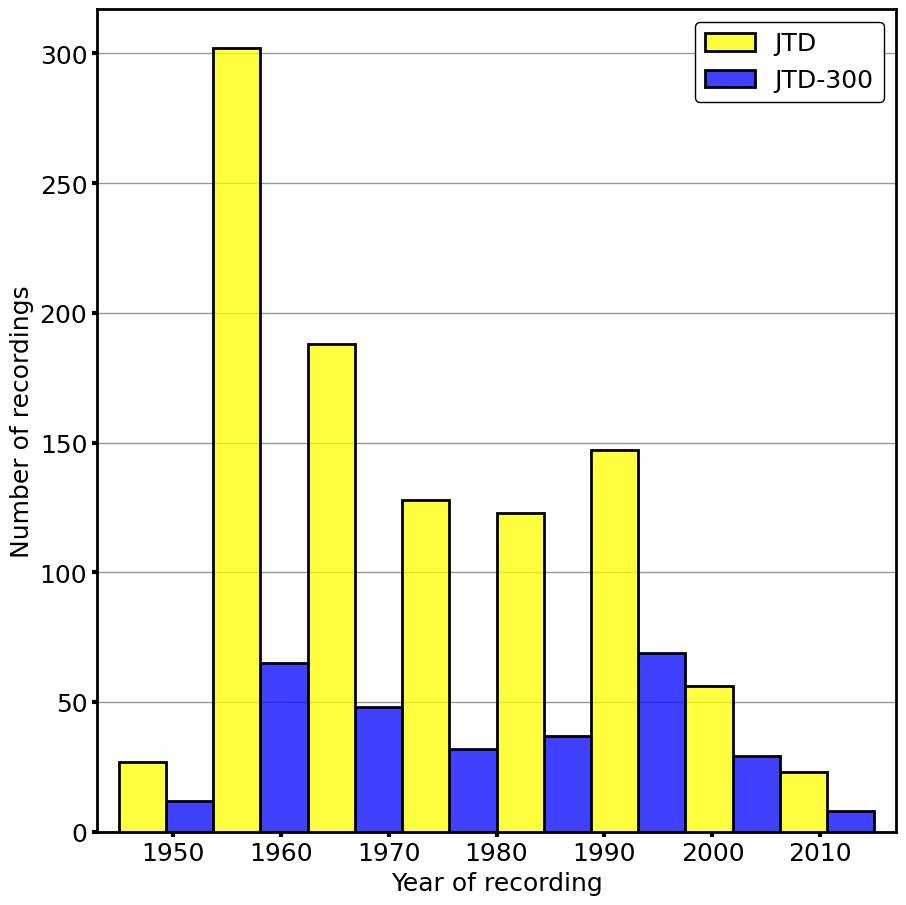

In [128]:
HistPlotRecordingYear(corp_df, corpus_title='jtd').create_plot()

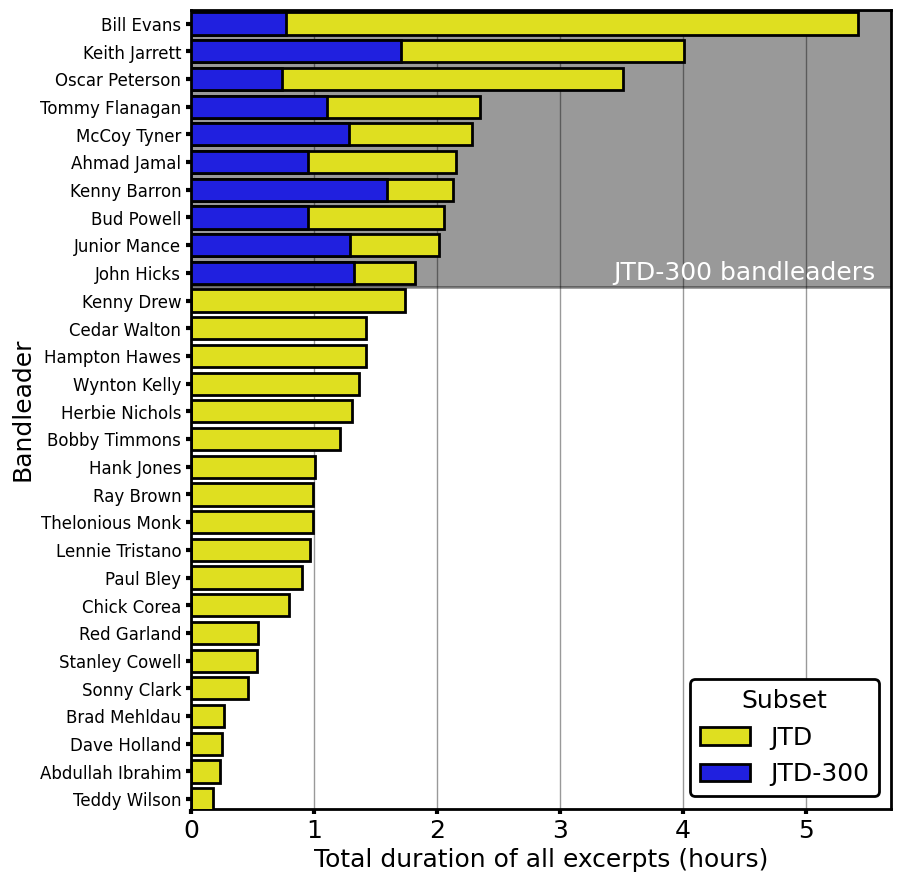

In [130]:
BarPlotBandleaderDuration(corp_df, corpus_title='jtd').create_plot()

## JTD-300 exploration

In [5]:
jtd300 = corp_df[corp_df['in_30_corpus']]
jtd300['excerpt_duration'].sum()

Timedelta('0 days 11:42:52')

In [79]:
jtd300['recording_year'].describe()

count     300.000000
mean     1978.263333
std        16.358668
min      1947.000000
25%      1962.000000
50%      1977.500000
75%      1993.000000
max      2015.000000
Name: recording_year, dtype: float64

In [74]:
jtd300['excerpt_duration'].sum() / corp_df['excerpt_duration'].sum()

0.26412305533983016

In [75]:
jtd300['bandleader'].value_counts()

Bud Powell        30
Kenny Barron      30
Junior Mance      30
John Hicks        30
Tommy Flanagan    30
McCoy Tyner       30
Ahmad Jamal       30
Bill Evans        30
Keith Jarrett     30
Oscar Peterson    30
Name: bandleader, dtype: int64

In [76]:
jtd300['time_signature'].value_counts(normalize=True)

4    0.946667
3    0.053333
Name: time_signature, dtype: float64

In [77]:
bls = jtd300['bandleader'].unique()
corp_df[corp_df['bandleader'].isin(bls)]['excerpt_duration'].sum() / corp_df['excerpt_duration'].sum()

0.6257359019966431

## Annotated subsample exploration

In [6]:
sub = corp_df[corp_df['has_annotations']]

In [86]:
len(sub)

34

In [87]:
sub['excerpt_duration'].sum()

Timedelta('0 days 01:12:00')

In [89]:
sub['recording_year'].describe()

count      34.000000
mean     1977.470588
std        18.663260
min      1947.000000
25%      1961.250000
50%      1975.000000
75%      1992.000000
max      2015.000000
Name: recording_year, dtype: float64

In [90]:
sub['time_signature'].value_counts(normalize=True)

4    0.882353
3    0.117647
Name: time_signature, dtype: float64

In [91]:
sub['bandleader'].value_counts(normalize=True)

Bill Evans        0.205882
McCoy Tyner       0.088235
Keith Jarrett     0.088235
Oscar Peterson    0.088235
Ahmad Jamal       0.088235
Kenny Barron      0.088235
Junior Mance      0.088235
Tommy Flanagan    0.088235
John Hicks        0.088235
Bud Powell        0.088235
Name: bandleader, dtype: float64

In [92]:
corp_df['bandleader'].value_counts(normalize=True)

Bill Evans          0.196291
Oscar Peterson      0.090417
Ahmad Jamal         0.056414
Keith Jarrett       0.051005
Tommy Flanagan      0.050232
McCoy Tyner         0.042504
Bud Powell          0.040958
Kenny Drew          0.037867
Herbie Nichols      0.036321
Kenny Barron        0.034003
Junior Mance        0.033230
Hampton Hawes       0.032457
John Hicks          0.031685
Cedar Walton        0.030139
Ray Brown           0.030139
Hank Jones          0.028594
Wynton Kelly        0.023957
Bobby Timmons       0.023957
Thelonious Monk     0.023184
Paul Bley           0.019320
Chick Corea         0.017774
Lennie Tristano     0.013910
Red Garland         0.013910
Stanley Cowell      0.009274
Sonny Clark         0.008501
Abdullah Ibrahim    0.007728
Teddy Wilson        0.006955
Dave Holland        0.005410
Brad Mehldau        0.003864
Name: bandleader, dtype: float64

## Plot distribution of recording years

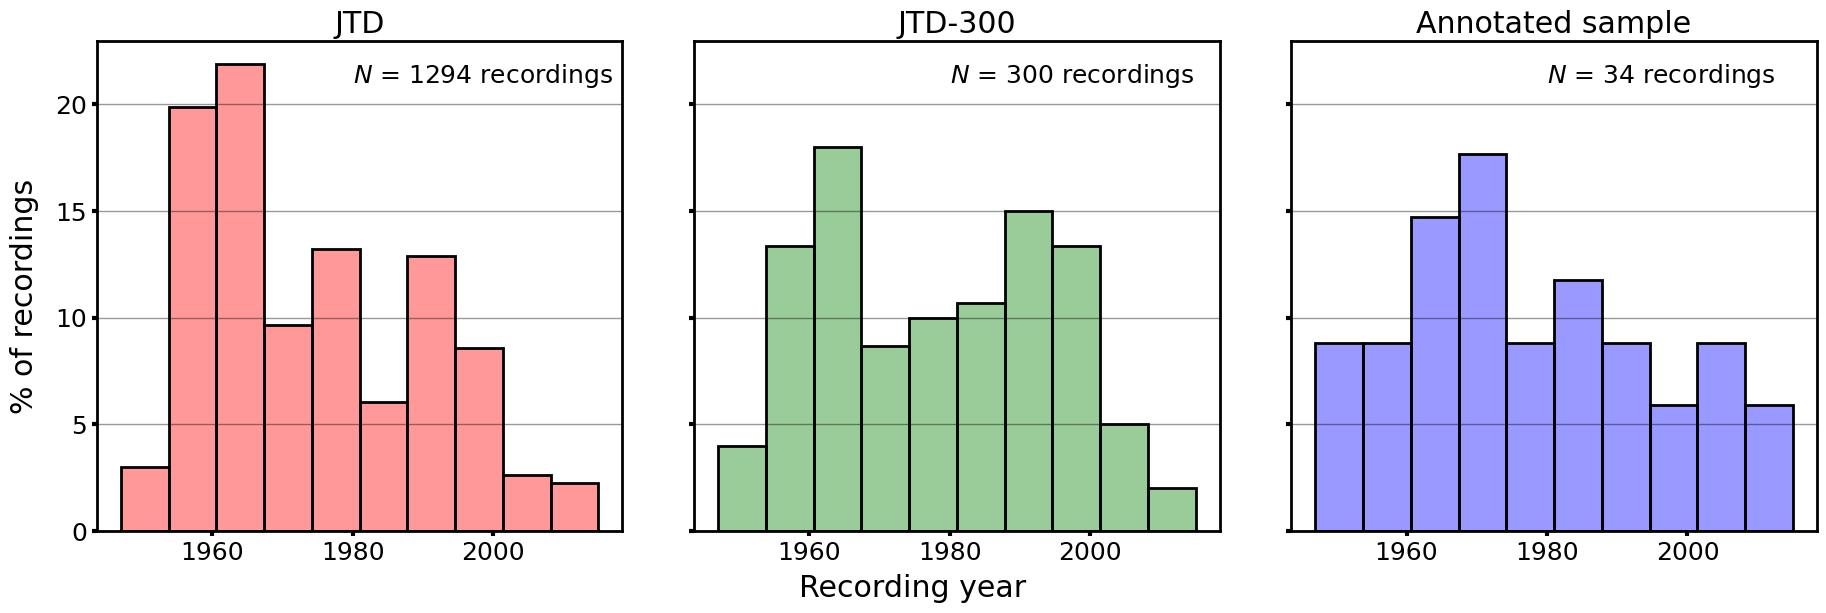

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import src.visualise.visualise_utils as vutils

plt.rcParams.update({'font.size': vutils.FONTSIZE})
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(vutils.WIDTH, vutils.WIDTH / 3))
for df, tit, a, col in zip([corp_df, jtd300, sub], ['JTD', 'JTD-300', 'Annotated sample'], ax.flatten(), vutils.RGB):
    sns.histplot(data=df, stat='percent', x='recording_year', bins=10, alpha=vutils.ALPHA, linewidth=vutils.LINEWIDTH, linestyle=vutils.LINESTYLE, color=col, ax=a)
    plt.setp(a.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
    a.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
    a.grid(visible=True, which='major', axis='y', **vutils.GRID_KWS)
    a.set(title=tit, xlabel='', ylabel='', )
    a.text(1980, 21, f'$N$ = {len(df)} recordings', )
fig.supylabel('% of recordings')
fig.supxlabel('Recording year')
fig.tight_layout()
fig.subplots_adjust(bottom=0.125)
fig.savefig(f'{utils.get_project_root()}/reports/figures/for_reviewers/year_distributions_by_subset.png')
plt.show()

## Number of panned tracks

In [78]:
1 - corp_df['channel_overrides'].value_counts(normalize=True)

{}                                           0.390263
{'bass': 'l', 'piano': 'r', 'drums': 'r'}    0.891808
{'bass': 'r', 'piano': 'l', 'drums': 'l'}    0.942813
{'bass': 'r', 'drums': 'l'}                  0.953632
{'bass': 'l', 'drums': 'r'}                  0.955951
{'bass': 'l', 'piano': 'r'}                  0.969861
{'piano': 'l', 'bass': 'r', 'drums': 'r'}    0.970634
{'piano': 'r', 'drums': 'l'}                 0.972179
{'piano': 'l', 'bass': 'r'}                  0.981453
{'piano': 'r', 'bass': 'l', 'drums': 'l'}    0.986862
{'drums': 'r', 'piano': 'l', 'bass': 'l'}    0.991499
{'piano': 'l', 'drums': 'r'}                 0.993818
{'drums': 'l', 'piano': 'r', 'bass': 'r'}    0.999227
Name: channel_overrides, dtype: float64

## Number of onsets

In [93]:
instrs = ['piano', 'bass', 'drums', 'mix', 'downbeats_auto']
ons_len = {instr: 0 for instr in instrs}
for track in corp:
    for instr in instrs:
        ons_len[instr] += len(track.ons[instr])
print(ons_len)

{'piano': 866116, 'bass': 543693, 'drums': 796604, 'mix': 512272, 'downbeats_auto': 130547}


In [6]:
ons_len['piano'] + ons_len['bass'] + ons_len['drums']

2206413

In [7]:
ons_len['downbeats_auto'] / ons_len['mix']

0.25483922603616826

## Average number of onsets

In [8]:
instrs = ['piano', 'bass', 'drums', 'mix', 'downbeats_auto']
ons_avg = {instr: [] for instr in instrs}
for track in corp:
    for instr in instrs:
        ons_avg[instr].append(len(track.ons[instr]))
for instr in instrs:
    print(instr, np.mean(ons_avg[instr]))

piano 669.3323029366306
bass 420.1646058732612
drums 615.613601236476
mix 395.8825347758887
downbeats_auto 100.88639876352396


## Onbeat/offbeat percentage

In [9]:
onob = {instr: 0 for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()}
for track in corp:
    df = pd.DataFrame(track.summary_dict)
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        onob[instr] += df[instr].isna().sum()

In [10]:
for instr, val in onob.items():
    print(instr, 1 - val / ons_len['mix'])

piano 0.7095683543117719
bass 0.82028492675766
drums 0.8739810100883906


## Solo duration

In [134]:
corp_df['excerpt_duration'].sum()

159668.0

In [135]:
corp_df[corp_df['excerpt_duration'] == corp_df['excerpt_duration'].min()]

,track_name,album_name,recording_year,in_30_corpus,bandleader,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,tempo,validation,stem_silent_perc,excerpt_duration_30,instr
803,Salt Peanuts,Swingin With Bud,1956,True,Bud Powell,Bud Powell,{},4acaf193-bdf2-4055-9418-e7feb0d1eca9,,4,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,22.0,"{'start': '01:04', 'end': '01:26'}",[],"{'pianist': 'Bud Powell', 'bassist': 'George D...","{'musicians': {'pianist': None, 'bassist': Non...",powellb-saltpeanuts-duviviergtaylora-1956-4aca...,174.115922,"{'piano': None, 'bass': None, 'drums': None, '...","{'piano': 0.011210762331838486, 'bass': 0.0341...",22.0,pianist


In [136]:
corp_df[corp_df['excerpt_duration'] == corp_df['excerpt_duration'].max()]

,track_name,album_name,recording_year,in_30_corpus,bandleader,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,tempo,validation,stem_silent_perc,excerpt_duration_30,instr
330,Reets and I,At the Golden Circle Volume 4,1962,False,Bud Powell,Bud Powell,{},c04edcb9-e573-454b-9120-a0d3c21d3dc1,,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,437.0,"{'start': '00:42', 'end': '07:59'}",[],"{'pianist': 'Bud Powell', 'bassist': 'Torbjorn...","{'musicians': {'pianist': None, 'bassist': Non...",powellb-reetsandi-hultcrantztspangbergs-1962-c...,193.256338,"{'piano': None, 'bass': None, 'drums': None, '...","{'piano': 0.0, 'bass': 0.43257145015726506, 'd...",NaN,pianist


In [137]:
pno = corp_df[~corp_df['bandleader'].isin(['Ray Brown', 'Dave Holland'])]
grouped = pno.groupby('bandleader')['excerpt_duration'].mean().sort_values()
short = grouped.head(9).index
long = grouped.tail(9).index

In [138]:
pno[pno['bandleader'].isin(short)].groupby('bandleader')['recording_year'].min().median()

1956.0

In [139]:
pno[pno['bandleader'].isin(long)].groupby('bandleader')['recording_year'].min().median()

1967.0

## Tempo exploration

In [4]:
instrs = ['piano', 'bass', 'drums']
res = []
for track in corp:
    # Convert the summary dictionary to a dataframe and subset to get beats played by the trio
    df = pd.DataFrame(track.summary_dict)
    my_beats = get_beats_from_matched_onsets(track.summary_dict)
    # Convert the beats to bpms
    my_bpms = 60 / my_beats.diff()
    # Extract the tempo slope
    ts = TempoSlope(my_beats).summary_dict['tempo_slope']
    if abs(ts) > 1:
        ts = np.nan
    # Extract the tempo fluctuation
    tf = np.nanstd(my_bpms) / np.nanmean(my_bpms)
    # Append the results to a dataframe
    res.append(dict(
        **track.item,
        missing=my_beats.isna().sum(),
        total_beats=len(df),
        tempo_slope=ts,
        tempo_man=np.nanmean(my_bpms),
        tempo_fluctuation=tf
    ))
df = pd.DataFrame(res)

In [122]:
1 - (df['missing'].sum() / df['total_beats'].sum())

0.8874035668551082

In [13]:
df['tempo_slope_abs'] = df['tempo_slope'].abs()
df[['tempo_slope', 'tempo_slope_abs', 'tempo_man', 'tempo_fluctuation', 'tempo']].describe()

,tempo_slope,tempo_slope_abs,tempo_man,tempo_fluctuation,tempo
count,1290.000000,1290.000000,1293.000000,1293.000000,1294.000000
mean,0.041085,0.065660,193.917148,0.055494,193.697644
std,0.099927,0.085791,46.931113,0.026995,46.593622
min,-0.674185,0.000015,102.100149,0.021718,102.061065
25%,-0.005061,0.017532,154.981222,0.043309,155.399754
50%,0.026972,0.039883,193.580801,0.051168,193.318421
75%,0.070884,0.078967,227.035652,0.059506,226.692039
max,0.868817,0.868817,299.824125,0.333764,299.308922


In [14]:
df[['tempo_slope_abs', 'tempo_slope', 'tempo_man', 'tempo_fluctuation']].dropna().corr()

,tempo_slope_abs,tempo_slope,tempo_man,tempo_fluctuation
tempo_slope_abs,1.000000,0.596435,0.281284,0.369972
tempo_slope,0.596435,1.000000,0.251001,-0.058038
tempo_man,0.281284,0.251001,1.000000,0.241753
tempo_fluctuation,0.369972,-0.058038,0.241753,1.000000


## Plot tempo histogram

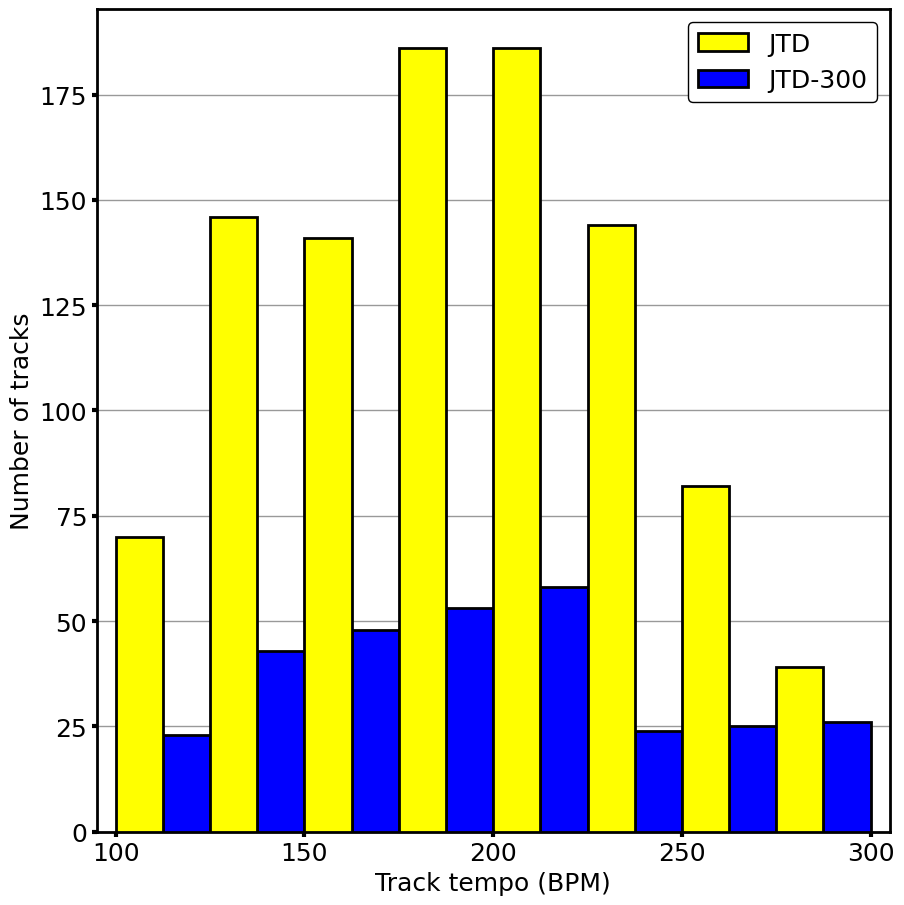

In [125]:
HistPlotTempo(df).create_plot()